# U.S. Presidential Election
## Libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

import sys

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

import seaborn as sns
sns.set()

import utils

import networkx as nx

from giotto.mapper import mapper as mp
from giotto.mapper import visualize

from sklearn.decomposition import PCA

In [2]:
# define color map to use
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",
                                                           ["blue", "violet", "red"])

In [3]:
df = pd.read_pickle(os.path.join('data',
                                 'usa_election_full_dataset.pickle'))

df.head()

,year,state,county,fips,pres,republican,democrat,total_votes,n_electors,winner,...,Farm proprietors' income,Nonfarm proprietors' income,Total employment (number of jobs),Wage and salary employment,Proprietors employment,Farm proprietors employment 6/,Nonfarm proprietors employment,Average earnings per job (dollars),Average wages and salaries,Average nonfarm proprietors' income
0,2000,Alabama,Autauga,01001,1,11993.0,4942.0,17208.0,0.088988,1,...,8519.0,54075.0,16138.0,11884.0,4254.0,404.0,3850.0,25707.0,24447.0,14045.0
1,2000,Alabama,Baldwin,01003,1,40872.0,13997.0,56480.0,0.285721,1,...,7003.0,282926.0,69423.0,53281.0,16142.0,1143.0,14999.0,25382.0,22593.0,18863.0
2,2000,Alabama,Barbour,01005,1,5096.0,5188.0,10395.0,0.058653,0,...,19495.0,23680.0,15146.0,12846.0,2300.0,546.0,1754.0,26907.0,22749.0,13501.0
3,2000,Alabama,Bibb,01007,1,4273.0,2710.0,7101.0,0.040254,1,...,3323.0,14631.0,6029.0,4609.0,1420.0,204.0,1216.0,24135.0,22165.0,12032.0
4,2000,Alabama,Blount,01009,1,12667.0,4977.0,17973.0,0.103312,1,...,26244.0,61227.0,16255.0,10490.0,5765.0,1382.0,4383.0,22830.0,21913.0,13969.0


In [4]:
data = utils.get_data(df)
data_per_year = utils.split_data_by_year(data, df)

### Mapper
#### Standard PCA

In [5]:
pipe = mp.make_mapper_pipeline()
graph = pipe.fit_transform(data_per_year['2016'])

In [6]:
seed = 1

node_elements = nx.get_node_attributes(graph, 'elements')
pos = nx.spring_layout(graph, seed=seed, dim=2)

node_color = utils.get_node_summary(node_elements,
                                    df[df['year'] == 2016]['winner'].values,
                                    summary_stat=np.mean)
custom_plot_options = {'node_trace_marker_colorscale': 'RdBu',
                       'node_trace_marker_reversescale': True}

visualize.create_network_2d(graph, pos, node_color, node_scale=20,
                            custom_plot_options=custom_plot_options)

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': '#888', 'width': 0.5},
     …

#### Custom PCA Filter

In [7]:
pca = PCA(n_components=2)

Text(0.5, 1.0, 'Transformed PCA 2')

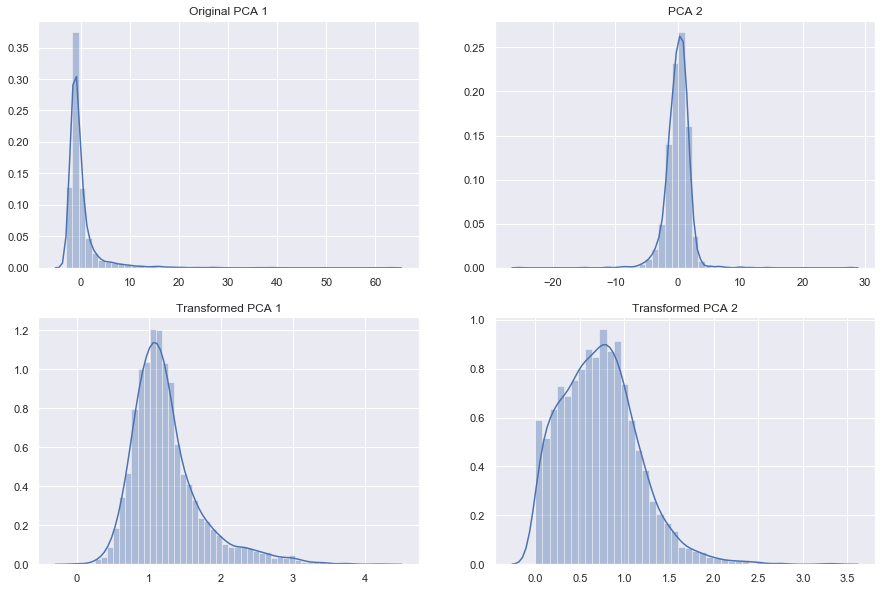

In [8]:
filtr_vals = pca.fit_transform(data_per_year['2016'])

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# pca 1
(sns.distplot(filtr_vals[:, 0],
              ax=ax[0, 0])
 .set_title('Original PCA 1'))
(sns.distplot(np.log(filtr_vals[:, 0] - min(filtr_vals[:, 0]) + 1),
              ax=ax[1, 0])
 .set_title('Transformed PCA 1'))

# pca 2
(sns.distplot(filtr_vals[:, 1],
              ax=ax[0, 1])
 .set_title('PCA 2'))
(sns.distplot(np.log(np.abs(filtr_vals[:, 1]) + 1),
              ax=ax[1, 1])
 .set_title('Transformed PCA 2'))

In [9]:
def filter_trafo(x):
    x[:, 0] = np.log(x[:, 0] - min(x[:, 0]) + 1)
    x[:, 1] = np.log(np.abs(x[:, 1]) + 1)
    return x

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

filter_func = Pipeline([('pca', pca), ('trafo', FunctionTransformer(filter_trafo))])

In [10]:
pipe = mp.make_mapper_pipeline(filter_func=filter_func)
graph = pipe.fit_transform(data_per_year['2016'])

In [31]:
def get_node_text(node_elements):
    return list(map(lambda x: f'Node Id: {x[0]}<br>Node size: {len(x[1])}',
                    node_elements.items()))

In [32]:
seed = 0

node_elements = nx.get_node_attributes(graph, 'elements')
pos = nx.spring_layout(graph, seed=seed, dim=2)

node_color = utils.get_node_summary(node_elements,
                                    df[df['year'] == 2016]['winner'].values,
                                    summary_stat=np.mean)

node_text = get_node_text(node_elements)

custom_plot_options = {'node_trace_marker_colorscale': 'RdBu',
                       'node_trace_marker_reversescale': True,
                       'node_trace_text': node_text}

visualize.create_network_2d(graph, pos, node_color, node_scale=20,
                            custom_plot_options=custom_plot_options)

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': '#888', 'width': 0.5},
     …

### Example for 3D Plot

In [ ]:
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex

seed = 14
pos = nx.spring_layout(graph, seed=seed, dim=3)

node_color = utils.get_node_summary(node_elements, data_per_year['2016'])

custom_plot_options = {'node_trace_marker_colorscale': 'RdBu',
                       'node_trace_marker_reversescale': True,
                       'node_trace_hoverlabel': dict(
                            bgcolor=list(map(lambda x: rgb2hex(get_cmap('RdBu_r')(x)),
                                             node_color)))}

visualize.create_network_3d(graph, pos, node_color,
                            node_scale=100, custom_plot_options=custom_plot_options)

### Interactive

In [ ]:
plotly_kwargs = {'custom_plot_options': {'node_trace_marker_reversescale': True,
                                         'node_trace_marker_colorscale': 'RdBu'}}
visualize.create_interactive_network(pipe, data_per_year['2016'],
                                     plotly_kwargs=plotly_kwargs,
                                     summary_stat=np.mean)